## Intermediate Setup

The idea is to optimize the network further to get a robust network

### Pipeline 
1. Data Loader abstracted to use separate augmentation file
2. Model moved to a separate file
3. Add Data Visualization module for Dataset and Incorrect Prediction

### Targets
1. Create an optimized model below **8,000** params
2. Analyze Outputs

### Results
1. Prepared a network with **3,762** params
2. Trained for 15 Epochs and reached an accuracy of **98.89%** Train and **99.19%** Test

### Analysis
1. While looking at training accuracy we can see there is a huge potential in the network to further train
2. This is a good network and can be used in further finetuning
3. While looking at failed predictions we see some of the predictions are obvious and can be trained into the network

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# The GPU id to use, "0" to  "7"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
from __future__ import print_function

In [6]:
import torch
import matplotlib.pyplot as plt

torch.manual_seed(1)

batch_size = 32
class_map = {
    'ZERO': 0,
    'ONE': 1,
    'TWO': 2,
    'THREE': 3,
    'FOUR': 4,
    'FIVE': 5,
    'SIX': 6,
    'SEVEN': 7,
    'EIGHT': 8,
    'NINE': 9
}
show_summary = True
show_dataset_analyze = False

In [7]:
# Load Network and Print Summary
from mnist.model import Net
from mnist.utils import get_device, print_summary

# Check GPU availability
use_cuda, device = get_device()

if show_summary:
    model = Net().to(device)
    print_summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 4, 28, 28]              40
       BatchNorm2d-2            [-1, 4, 28, 28]               8
            Conv2d-3            [-1, 4, 28, 28]             148
       BatchNorm2d-4            [-1, 4, 28, 28]               8
            Conv2d-5            [-1, 4, 28, 28]             148
       BatchNorm2d-6            [-1, 4, 28, 28]               8
         MaxPool2d-7            [-1, 4, 14, 14]               0
           Dropout-8            [-1, 4, 14, 14]               0
            Conv2d-9            [-1, 8, 14, 14]             296
      BatchNorm2d-10            [-1, 8, 14, 14]              16
           Conv2d-11            [-1, 8, 14, 14]             584
      BatchNorm2d-12            [-1, 8, 14, 14]              16
           Conv2d-13            [-1, 8, 14, 14]             584
      BatchNorm2d-14            [-1, 8,

In [8]:
from mnist.dataset import get_loader
from mnist.transform import get_a_train_transform, get_a_test_transform

train_loader, test_loader = get_loader(get_a_train_transform(), get_a_test_transform(), batch_size=batch_size, use_cuda=use_cuda)

In [9]:
## Calculate Class Scale
from mnist.visualize import print_class_scale, print_samples
if show_dataset_analyze:
    print_class_scale(train_loader, class_map)
    print_samples(train_loader)

In [10]:
import time
import math

from mnist.backpropagation import train, test, get_sgd_optimizer
from mnist.utils import initialize_weights
from mnist.scheduler import one_cycle_lr_pt, one_cycle_lr_custom
from mnist.training import Training

# Train Params
epochs = 15
lr = 0.05
max_lr = 0.1
steps_per_epoch = len(train_loader)
dropout = True
momentum = 0.9
weight_decay = 0

print("Using Device:", device)
print("Epochs:", epochs)
print("Lr:", lr)
print("Max Lr:", max_lr)
print("Batch Size:", batch_size)
print("Dropout:", dropout)
print("\n")

model = Net().apply(initialize_weights).to(device)
optimizer = get_sgd_optimizer(model, lr=lr)

# Pytorch one cycle scheduler
pytorch_scheduler = one_cycle_lr_pt(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

# One cycle schedule with a custom function
custom_scheduler = one_cycle_lr_custom(
    optimizer, 
    lr=lr, 
    max_lr=max_lr, 
    steps_per_epoch=steps_per_epoch, 
    epochs=epochs, 
    anneal_strategy='linear'
)

trainer = Training(
    model,
    optimizer,
    None,
    train(),
    test,
    train_loader,
    test_loader,
    lr,
    epochs,
    device,
    dropout
)

trainer.run()

Using Device: cuda
Epochs: 15
Lr: 0.05
Max Lr: 0.1
Batch Size: 32
Dropout: True


| Epoch | LR       | Time    | TrainLoss | TrainCorrect | TrainAcc | ValLoss  | ValCorrect | ValAcc |
|     1 | 0.050000 | 00m 17s | 0.292458  |        54328 | 90.55  % | 0.071437 |       9780 | 97.8 % |
|     2 | 0.050000 | 00m 16s | 0.095238  |        58294 | 97.16  % | 0.058214 |       9809 | 98.09% |
|     3 | 0.050000 | 00m 16s | 0.073288  |        58654 | 97.76  % | 0.047066 |       9837 | 98.37% |
|     4 | 0.050000 | 00m 16s | 0.063835  |        58799 | 98.0   % | 0.043862 |       9854 | 98.54% |
|     5 | 0.050000 | 00m 16s | 0.05721   |        58965 | 98.28  % | 0.040318 |       9866 | 98.66% |
|     6 | 0.050000 | 00m 16s | 0.052206  |        59041 | 98.4   % | 0.031956 |       9893 | 98.93% |
|     7 | 0.050000 | 00m 16s | 0.048467  |        59111 | 98.52  % | 0.027043 |       9917 | 99.17% |
|     8 | 0.050000 | 00m 17s | 0.046998  |        59122 | 98.54  % | 0.031052 |       9896 | 98.96% |


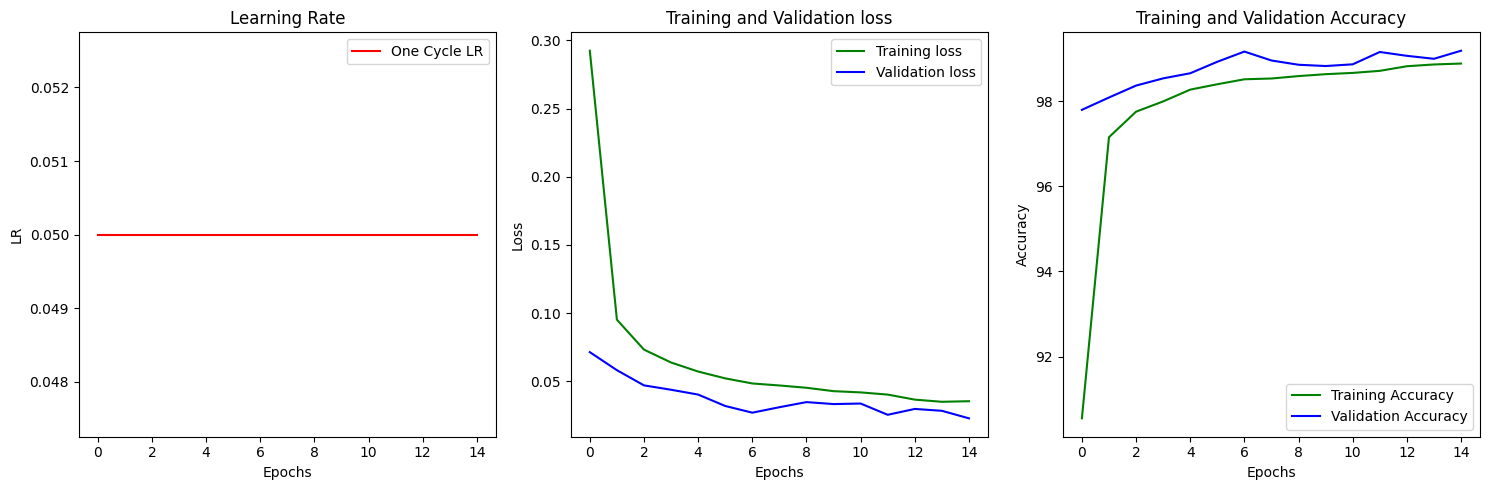

In [11]:
from mnist.visualize import plot_network_performance

# trainer.print_best_model()
plot_network_performance(epochs, trainer.schedule, trainer.list_train_loss, trainer.list_valid_loss, trainer.list_train_correct, trainer.list_valid_correct)

## Analyze Network

Confusion matrix, without normalization


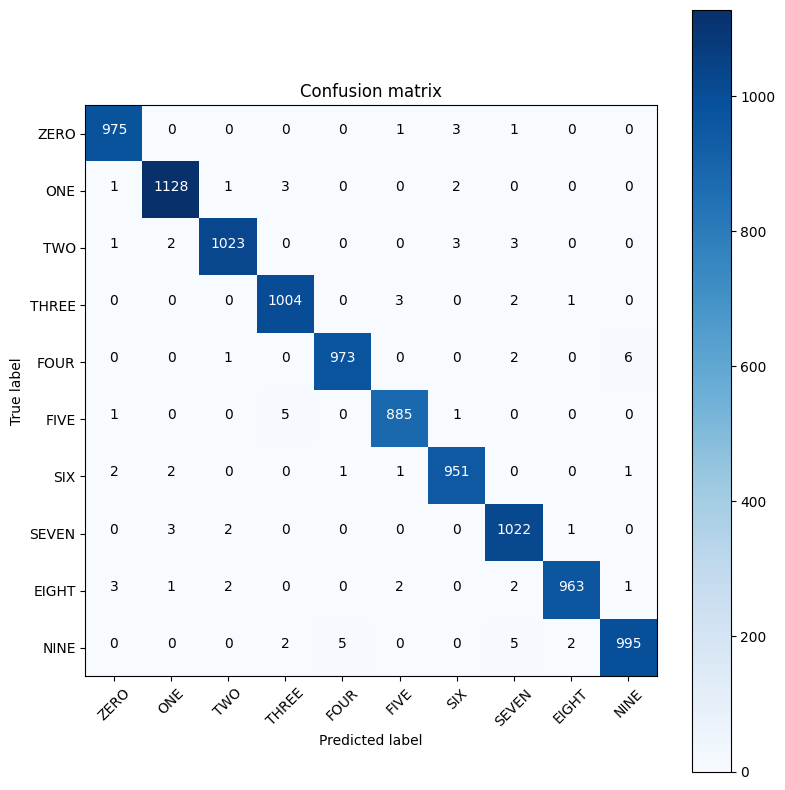

In [12]:
from mnist.utils import get_all_predictions, get_incorrrect_predictions, prepare_confusion_matrix
from mnist.visualize import plot_confusion_matrix

all_preds, all_targets = get_all_predictions(model, test_loader, device)
confusion_matrix = prepare_confusion_matrix(all_preds, all_targets, class_map)
plot_confusion_matrix(confusion_matrix, class_map, False)

Total Incorrect Predictions 81


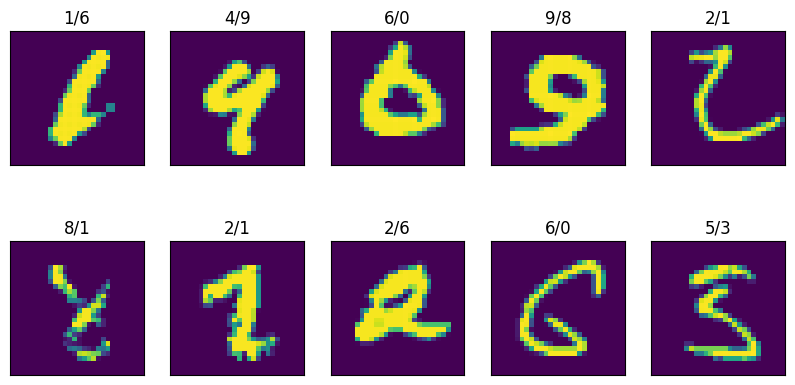

In [13]:
from mnist.utils import get_incorrrect_predictions
from mnist.visualize import plot_incorrect_predictions

incorrect = get_incorrrect_predictions(model, test_loader, device)
plot_incorrect_predictions(incorrect, class_map)